In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
# !jupyter labextension install jupyterlab-plotly@4.7.1

In [2]:
#!pip install chart_studio
#!conda install -c conda-forge cufflinks-py -y

In [3]:
# import chart_studio.plotly as py
# import plotly.graph_objs as go
# import plotly
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# import cufflinks as cf
# cf.set_config_file(offline=True)

In [3]:
os.chdir('../')

In [42]:
data = pd.read_pickle('data/procesada/data_with_index.pkl')
# data['analyst_decision'] = pd.Categorical(data['model_decision'], ['A', 'R', 'G', 'NA_string', 'error'])
# data['model_decision'] = pd.Categorical(data['model_decision'], ['A', 'R', 'NA_string'])

In [6]:
count_data = (pd.crosstab(data.model_decision, data.analyst_decision, normalize='index')*100).reset_index()
count_data = count_data.loc[:, ['model_decision', 'A', 'R', 'NA_string']]
count_data['model_decision'] = pd.Categorical(count_data['model_decision'], ['A', 'R', 'G','NA_string', 'error'])
count_data = count_data.sort_values('model_decision',ascending=False)

In [7]:
cross_data = pd.crosstab(data[['model_decision', 'analyst_decision']].melt().variable,
            data[['model_decision', 'analyst_decision']].melt().value).reset_index().melt(id_vars='variable', var_name='output')
cross_data['output'] = pd.Categorical(cross_data['output'], ['A', 'R', 'G', 'NA_string', 'error'])

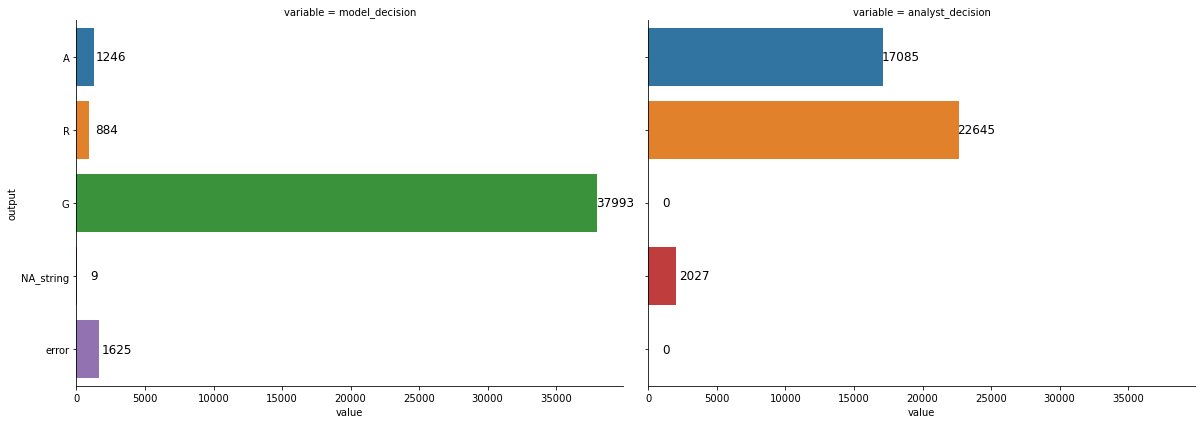

In [8]:
g = sns.catplot(y='output', x='value', col='variable', kind='bar',
            data=cross_data ,
           height=6, aspect=1.4, col_order=['model_decision', 'analyst_decision'])

for ax_i in g.axes[0]:
    for i, bar in enumerate(ax_i.patches):
        h = bar.get_width()
        ax_i.text(
            h+1300, # bar index (x coordinate of text)
            i, # y coordinate of text
            '{}'.format(int(h)),  # y label
            ha='center', 
            va='center', 
            size=12)

# g.axes[0][1].text(500, 2, 's')
plt.tight_layout()
plt.show()

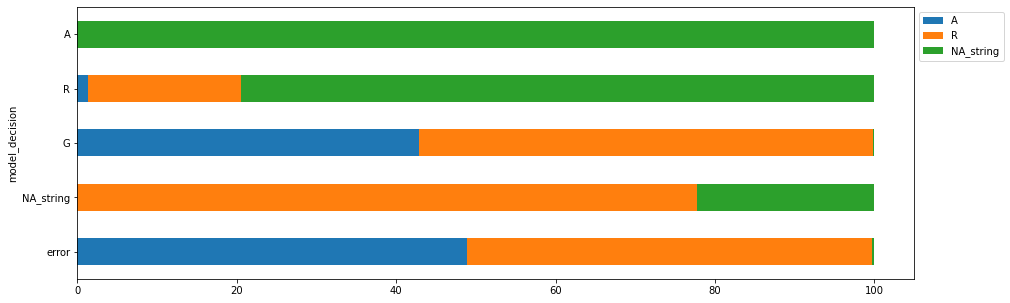

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
count_data.plot(x='model_decision', kind='barh', stacked=True, ax=ax)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [10]:
# (data.analyst_decision.value_counts(normalize=True)*100).reset_index().iplot(x='index', kind='bar', theme='white')

In [11]:
# count_data.iplot(kind='bar', barmode='stack', x='analyst_decision', theme='white')

In [12]:
print('{0:.1%} de la base tiene duplicados'.format(data.sort_values(by=['state','lat', 'long']).duplicated(subset=['lat', 'long'], keep=False).mean()))

33.1% de la base tiene duplicados


¿En qué estados es la proporción de duplicados más alta?

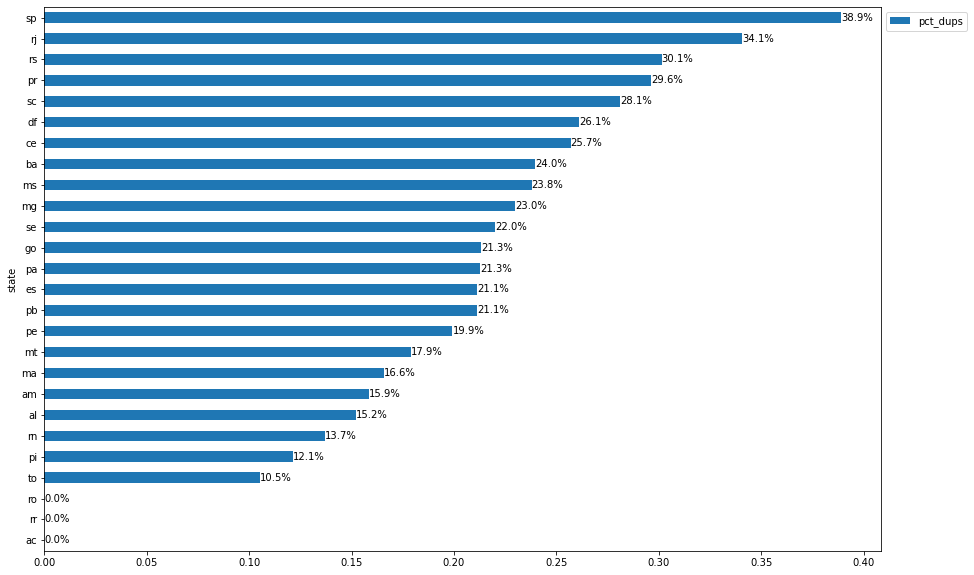

In [13]:
dup_data_states = (data
 .groupby('state')
 .apply(lambda df: df.duplicated(subset=['lat', 'long'], keep=False).mean())
 .reset_index()
 .rename(columns={0: 'pct_dups'})
 .sort_values(by='pct_dups')
                   .reset_index(drop=True)
)

fig, ax = plt.subplots(figsize=(15, 10))
dup_data_states.plot(kind='barh', y='pct_dups', x='state',ax=ax)

for idx, row in dup_data_states.iterrows():
    ax.text(row['pct_dups'],
            idx, 
            '{0:.1%}'.format(row['pct_dups']),
            va='center', 
           )
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Pueden haber decisiones diferentes de analista y modelo, de está manera se buscar homogeneisar la decisión final

In [14]:
data = data.assign(final_decision=lambda x: np.where(x.analyst_decision.isin(['A', 'R']), x.analyst_decision, 
                                                    np.where(x.model_decision.isin(['A', 'R']),
                                                             x.model_decision,
                                                             'undefined')))

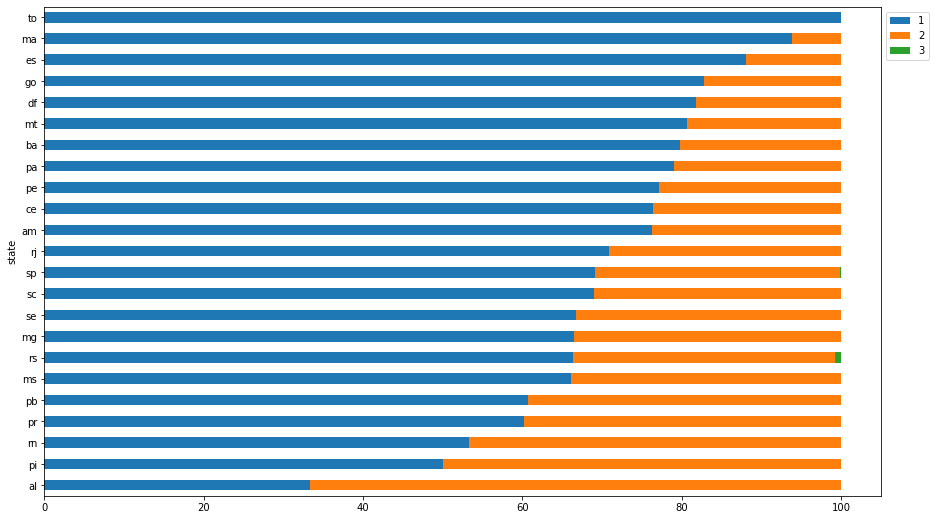

In [15]:
agg_dups_data = (data
                 .assign(tag_dup=lambda x: np.where(x.duplicated(subset=['state', 'lat', 'long'], keep=False), 'has_dups', 'no_dups'))
                 .query('tag_dup=="has_dups"')
                 .groupby(['tag_dup','state', 'lat', 'long'])
                 .agg(len_final=('final_decision', lambda x: len(x)),
                      len_unique_final=('final_decision', lambda x: len(x.unique())))
                 .reset_index()
                )

data_dups_state = (agg_dups_data[['state', 'len_unique_final']]
 .groupby('state')
 .apply(lambda df: df.len_unique_final.value_counts(normalize=True)*100)
 .reset_index()
 .pivot_table(values='len_unique_final',
              index='state',
              columns='level_1',
             fill_value=0)
 .reset_index()
 .sort_values(by=[1], ascending=True)
)

fig, ax = plt.subplots(figsize=(15, 9))
data_dups_state.plot(x='state', kind='barh', stacked=True, ax=ax)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

En los duplicados, hay más de una decisión?

Excluyendo duplicados: donde la decisión es unanime se deja la decisión de todas las ubicaciones, de lo contrario se toma la decisión de la mayoría; en los casos de empate. aleatoriamente se selecciona una decisión

In [16]:
np.random.seed(2020)
data = (data
 .assign(uno=1)
 .groupby(['state','census_code','lat', 'long','final_decision'])
 .agg(count=('uno', sum))
 .reset_index()
 .assign(random_index=lambda x: np.random.normal(size=x.shape[0]))
 .sort_values(by=['state', 'lat', 'long','count', 'random_index'], ascending=False)
 .drop_duplicates(subset=['census_code','state', 'lat', 'long'], keep='first')
 .drop(columns=['count', 'random_index'])
 .reset_index(drop=True)
)

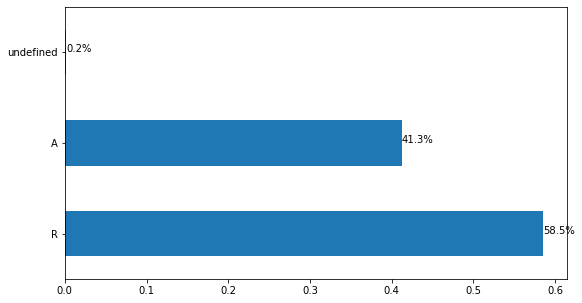

In [17]:
fig, ax = plt.subplots(figsize=(9, 5))
data.final_decision.value_counts(normalize=True).plot.barh(ax=ax)
for idx, text_i in enumerate(data.final_decision.value_counts(normalize=True)[['R', 'A', 'undefined']]):
    plt.text(text_i, idx, '{0:.1%}'.format(text_i))
plt.show()

In [18]:
data

,state,census_code,lat,long,final_decision
0,sp,351550905000079,-20.263983,-50.247906,R
1,sp,351550905000079,-20.265123,-50.255143,R
2,sp,351550905000079,-20.266660,-50.254667,A
3,sp,351550905000058,-20.267959,-50.262205,R
4,sp,351550905000042,-20.268545,-50.241478,R
...,...,...,...,...,...
32127,al,270030005000062,-9.761259,-36.654615,R
32128,al,270030005000058,-9.766242,-36.641586,R
32129,al,270030005000058,-9.766306,-36.643756,A
32130,al,270030005000058,-9.767589,-36.642200,R
